# Learning to Play the Zoning Game: Supervised

Let's actually do some machine learning. Here, we will train a neural network to mimic a greedy policy and a greedy value function by supervised learning. We will play a bunch of random games and take the output of some greedy policy (either `polich_indiv_greedy` or `policy_total_greedy`), alongside the "current grid score," as training data for a neural network with a policy head and a value head.

In [1]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from nsai_experiments.zoning_game.zg_gym import Tile
from nsai_experiments.zoning_game.zg_policy import create_policy_random, create_policy_indiv_greedy, create_policy_indiv_greedy_deterministic

from nsai_experiments.zoning_game.notebook_utils import get_zg_data

In [2]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(DEVICE)

cuda


## Part 1: no streaming, random policy, only train value
Here, we focus on a single-headed value network and we use a pre-determined policy to generate a bunch of data ahead of time.

In [3]:
shuffle_before_split = True
valid_frac = 0.15
test_frac = 0.15

torch.manual_seed(47)
# Not using moves data yet
states_tensor, values_tensor, _ = get_zg_data(create_policy_random, n_games = 100_000)

full_dataset = TensorDataset(states_tensor, values_tensor)
if shuffle_before_split:
    indices = torch.randperm(len(full_dataset))
    full_dataset = TensorDataset(states_tensor[indices], values_tensor[indices])

valid_size = int(valid_frac * len(full_dataset))
test_size = int(test_frac * len(full_dataset))
train_size = len(full_dataset) - valid_size - test_size

# Perform the split
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

print(f"Train size: {len(train_dataset)}, validation size: {len(valid_dataset)}, test size: {len(test_dataset)}")

Loading data from disk: zg_data/create_policy_random__100000
Train size: 1513124, validation size: 324240, test size: 324240


In [4]:
class StepOneValueNetwork(nn.Module):
    def __init__(self, grid_size = 6):
        super().__init__()
        self.grid_size = grid_size
        self.grid_length = grid_size*grid_size
        self.input_length = self.grid_length*2
        self.num_classes = len(Tile)

        kernel_size = 3
        out_channels = self.num_classes*kernel_size*kernel_size
        n_into_linear = self.grid_length*out_channels + self.grid_length*self.num_classes
        n_hidden = self.input_length*self.num_classes
        
        self.conv1 = nn.Conv2d(self.num_classes, out_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.linear_relu_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(n_into_linear, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU()
        )
        self.policy_head = nn.Linear(n_hidden, self.grid_length)
        self.value_head = nn.Linear(n_hidden, 1)


    def forward(self, x):
        assert x.shape[1] == self.input_length
        x = F.one_hot(x, num_classes=self.num_classes).to(torch.float32)

        x_grid = x[:, :self.grid_length, :].reshape(-1, self.grid_size, self.grid_size, self.num_classes)
        x_grid = self.conv1(x_grid)
        x_grid = torch.flatten(x_grid, start_dim=1)

        x_queue = x[:, self.grid_length:]
        x_queue = torch.flatten(x_queue, start_dim=1)

        x = torch.cat((x_grid, x_queue), dim=1)
        x = self.linear_relu_stack(x)
        x = self.value_head(x)
        return x

In [5]:
def train_step_one_value_network(model, train_dataset, valid_dataset, epochs=10, batch_size=1024, learning_rate=0.002, l1_lambda = 1e-4, weight_decay = 5e-2, device = DEVICE):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    torch.manual_seed(47)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    train_mini_losses = []
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            loss = loss.item()
            train_mini_losses.append(loss)
            train_loss += loss

        # Validation phase
        model.eval()
        valid_loss = 0.0
        abs_differences = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                valid_loss += loss.item()
                abs_differences.extend(torch.abs(outputs.squeeze() - targets).cpu().numpy())

        # Record losses
        train_losses.append(train_loss / len(train_loader))
        valid_losses.append(valid_loss / len(val_loader))

        # Calculate max, min, and mean absolute differences
        max_abs_diff = np.max(abs_differences)
        min_abs_diff = np.min(abs_differences)
        mean_abs_diff = np.mean(abs_differences)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {valid_losses[-1]:.4f}, "
              f"Max Abs Diff: {max_abs_diff:.4f}, Min Abs Diff: {min_abs_diff:.4f}, Mean Abs Diff: {mean_abs_diff:.4f}")

    return model, train_mini_losses, train_losses, valid_losses

def plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = False):
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.scatter(np.linspace(0, len(train_losses)-1, len(train_mini_losses)), train_mini_losses, label="Training Mini Loss", s=5, color="gray")
    plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
    plt.plot(range(len(valid_losses)), valid_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    if log_scale: plt.yscale("log")
    plt.xlim([0, len(train_losses)-1])
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
# model = StepOneValueNetwork()
# model, train_mini_losses, train_losses, valid_losses = train_step_one_value_network(model, train_dataset, valid_dataset, epochs = 5)

# plot_learning_curve(train_mini_losses, train_losses, valid_losses)
# plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = True)

## Part 2: no streaming, individual greedy policy, only train policy

Success. Now, same thing but we want to learn the policy, not the value. We'll try to learn the `indiv_greedy` policy.

In [7]:
states_tensor, _, moves_tensor = get_zg_data(create_policy_indiv_greedy, n_games = 100_000)

print(states_tensor.shape)
print(moves_tensor.shape)

Loading data from disk: zg_data/create_policy_indiv_greedy__100000
torch.Size([2161604, 72])
torch.Size([2161604])


In [8]:
torch.manual_seed(47)
full_dataset_2 = TensorDataset(states_tensor, moves_tensor)
if shuffle_before_split:
    indices = torch.randperm(len(full_dataset_2))
    full_dataset_2 = TensorDataset(states_tensor[indices], moves_tensor[indices])

valid_size_2 = int(valid_frac * len(full_dataset_2))
test_size_2 = int(test_frac * len(full_dataset_2))
train_size_2 = len(full_dataset_2) - valid_size_2 - test_size_2

# Perform the split
train_dataset_2, valid_dataset_2, test_dataset_2 = random_split(full_dataset_2, [train_size_2, valid_size_2, test_size_2])

print(f"Train size: {len(train_dataset_2)}, validation size: {len(valid_dataset_2)}, test size: {len(test_dataset_2)}")

Train size: 1513124, validation size: 324240, test size: 324240


In [9]:
class StepTwoPolicyNetwork(nn.Module):
    def __init__(self, grid_size = 6):
        super().__init__()
        self.grid_size = grid_size
        self.grid_length = grid_size*grid_size
        self.input_length = self.grid_length*2
        self.num_classes = len(Tile)

        kernel_size = 3
        out_channels = self.num_classes*kernel_size*kernel_size
        n_into_linear = self.grid_length*out_channels + self.grid_length*self.num_classes
        n_hidden = self.input_length*self.num_classes
        
        self.conv1 = nn.Conv2d(self.num_classes, out_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.linear_relu_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(n_into_linear, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU()
        )
        self.policy_head = nn.Linear(n_hidden, self.grid_length)
        self.value_head = nn.Linear(n_hidden, 1)


    def forward(self, x):
        assert x.shape[1] == self.input_length
        x = F.one_hot(x, num_classes=self.num_classes).to(torch.float32)

        x_grid = x[:, :self.grid_length, :].reshape(-1, self.grid_size, self.grid_size, self.num_classes)
        x_grid = self.conv1(x_grid)
        x_grid = torch.flatten(x_grid, start_dim=1)

        x_queue = x[:, self.grid_length:]
        x_queue = torch.flatten(x_queue, start_dim=1)

        x = torch.cat((x_grid, x_queue), dim=1)
        x = self.linear_relu_stack(x)
        x = self.policy_head(x)
        return x

In [10]:
def train_step_two_policy_network(model, train_dataset, valid_dataset, epochs=10, batch_size=1024, learning_rate=0.001, l1_lambda = 0, weight_decay = 5e-3, device = DEVICE):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    train_mini_losses = []
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            loss = loss.item()
            train_mini_losses.append(loss)
            train_loss += loss

        # Validation phase
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                valid_loss += loss.item()

        # Record losses
        train_losses.append(train_loss / len(train_loader))
        valid_losses.append(valid_loss / len(val_loader))

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {valid_losses[-1]:.4f}, ")

    return model, train_mini_losses, train_losses, valid_losses

In [11]:
# model = StepTwoPolicyNetwork()
# model, train_mini_losses, train_losses, valid_losses = train_step_two_policy_network(model, train_dataset_2, valid_dataset_2, epochs = 5)

# plot_learning_curve(train_mini_losses, train_losses, valid_losses)
# plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = True)

## Part 3: no streaming, individual greedy policy, train both value and policy
Our value and policy nets look quite similar. Can we have one with two heads that does both? Also, let's:

  * use a deterministic variant of `policy_indiv_greedy` that breaks ties by cell index rather than randomly, so it should be theoretically possible to learn to perfectly mimic the policy
  * write the batch data handling ourselves, since in profiling (not shown) we've seen that a majority of the time is taken up with data handling

In [12]:
states_tensor, values_tensor, moves_tensor = get_zg_data(create_policy_indiv_greedy_deterministic, n_games = 100_000)
torch.manual_seed(47)
indices = torch.randperm(len(states_tensor))
states_tensor, values_tensor, moves_tensor = states_tensor[indices], values_tensor[indices], moves_tensor[indices]
states_tensor, values_tensor, moves_tensor = states_tensor.to(DEVICE), values_tensor.to(DEVICE), moves_tensor.to(DEVICE)

print(states_tensor.shape)
print(values_tensor.shape)
print(moves_tensor.shape)

def my_train_test_valid(states_tensor, values_tensor, moves_tensor):
    valid_size = int(valid_frac * len(states_tensor))
    test_size = int(test_frac * len(states_tensor))
    train_size = len(states_tensor) - valid_size - test_size
    cutoff1 = train_size
    cutoff2 = train_size+valid_size

    train_dataset = (states_tensor[:cutoff1], values_tensor[:cutoff1], moves_tensor[:cutoff1])
    valid_dataset = (states_tensor[cutoff1:cutoff2], values_tensor[cutoff1:cutoff2], moves_tensor[cutoff1:cutoff2])
    test_dataset = (states_tensor[cutoff2:], values_tensor[cutoff2:], moves_tensor[cutoff2:])

    return train_dataset, valid_dataset, test_dataset

train_dataset, valid_dataset, test_dataset = my_train_test_valid(states_tensor, values_tensor, moves_tensor)
print(f"Train size: {len(train_dataset[0])}, validation size: {len(valid_dataset[0])}, test size: {len(test_dataset[0])}")


Loading data from disk: zg_data/create_policy_indiv_greedy_deterministic__100000
torch.Size([2161604, 72])
torch.Size([2161604])
torch.Size([2161604])
Train size: 1513124, validation size: 324240, test size: 324240


In [13]:
class StepThreeComboNetwork(nn.Module):
    def __init__(self, grid_size = 6):
        super().__init__()
        self.grid_size = grid_size
        self.grid_length = grid_size*grid_size
        self.input_length = self.grid_length*2
        self.num_classes = len(Tile)

        kernel_size = 3
        out_channels = self.num_classes*kernel_size*kernel_size
        n_into_linear = self.grid_length*out_channels + self.grid_length*self.num_classes
        n_hidden = self.input_length*self.num_classes
        
        self.conv1 = nn.Conv2d(self.num_classes, out_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.linear_relu_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(n_into_linear, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU()
        )
        self.policy_head = nn.Linear(n_hidden, self.grid_length)
        self.value_head = nn.Linear(n_hidden, 1)


    def forward(self, x):
        assert x.shape[1] == self.input_length
        x = F.one_hot(x, num_classes=self.num_classes).to(torch.float32)

        x_grid = x[:, :self.grid_length, :].reshape(-1, self.grid_size, self.grid_size, self.num_classes)
        x_grid = self.conv1(x_grid)
        x_grid = torch.flatten(x_grid, start_dim=1)

        x_queue = x[:, self.grid_length:]
        x_queue = torch.flatten(x_queue, start_dim=1)

        x = torch.cat((x_grid, x_queue), dim=1)
        x = self.linear_relu_stack(x)

        y_value = self.value_head(x)
        y_policy = self.policy_head(x)
        return y_value, y_policy

In [46]:
def train_step_three_combo_network(model, train_dataset, valid_dataset,
                                  epochs=10, batch_size=2048, learning_rate=0.0005, l1_lambda = 0, weight_decay = 1e-3, device = DEVICE, seed=47,
                                  policy_weight = 1.0):
    model = model.to(device)
    criterion_value = nn.MSELoss()
    criterion_policy = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    train_inputs, train_value, train_policy = train_dataset
    valid_inputs, valid_value, valid_policy = valid_dataset
    n_batches = len(train_inputs)//batch_size

    train_mini_losses = []
    train_losses = []
    valid_losses = []
    valid_losses_value = []
    valid_losses_policy = []
    valid_accs_value = []
    valid_accs_policy = []

    torch.manual_seed(seed)
    for epoch in tqdm(range(epochs), file=sys.stdout):  # range(epochs)
        # Reshuffle test data every epoch
        indices = torch.randperm(len(train_inputs))
        train_inputs, train_value, train_policy = train_inputs[indices], train_value[indices], train_policy[indices]
        # Training phase
        model.train()
        train_loss = 0.0
        for i in range(n_batches):  # tqdm(range(n_batches))
            datarange = slice(batch_size*i, batch_size*(i+1))
            inputs, targets_value, targets_policy = train_inputs[datarange], train_value[datarange], train_policy[datarange]
            optimizer.zero_grad()
            outputs_value, outputs_policy = model(inputs)
            loss_value = criterion_value(outputs_value.squeeze(), targets_value)
            loss_policy = criterion_policy(outputs_policy.squeeze(), targets_policy)
            loss = loss_value + policy_weight*loss_policy

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            loss = loss.item()
            train_mini_losses.append(loss)
            train_loss += loss

        # Validation phase
        model.eval()
        valid_loss = 0.0
        valid_loss_value = 0.0
        valid_loss_policy = 0.0
        valid_acc_value = 0.0
        valid_acc_policy = 0.0
        with torch.no_grad():
            outputs_value, outputs_policy = model(valid_inputs)
            loss_value = criterion_value(outputs_value.squeeze(), valid_value)
            loss_policy = criterion_policy(outputs_policy.squeeze(), valid_policy)
            loss = loss_value + policy_weight*loss_policy
            valid_loss += loss.item()
            valid_loss_value += loss_value.item()
            valid_loss_policy += loss_policy.item()
            valid_acc_value += (torch.round(outputs_value.squeeze()) == valid_value).float().mean().item()
            valid_acc_policy += (torch.argmax(outputs_policy.squeeze(), dim = 1) == valid_policy).float().mean().item()

        # Record losses
        train_losses.append(train_loss / n_batches)
        valid_losses.append(valid_loss)
        valid_losses_value.append(valid_loss_value)
        valid_losses_policy.append(valid_loss_policy)
        valid_accs_value.append(valid_acc_value)
        valid_accs_policy.append(valid_acc_policy)

        # Print epoch summary
        tqdm.write(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.3f}, Val Loss: {valid_losses[-1]:.3f}, "
              f"Val Value Loss: {valid_losses_value[-1]:.3f}, Val Policy Loss: {valid_losses_policy[-1]:.3f}, "
              f"Val Value Accuracy: {valid_accs_value[-1]:.2%}, Val Policy Accuracy: {valid_accs_policy[-1]:.2%}")

    return model, train_mini_losses, train_losses, valid_losses, valid_losses_value, valid_losses_policy, valid_accs_value, valid_accs_policy

In [47]:
def plot_learning_curves(train_mini_losses, train_losses, valid_losses, valid_losses_value, valid_losses_policy, valid_accs_value, valid_accs_policy, figsize=(12, 4)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    ax1.scatter(np.linspace(0, len(train_losses)-1, len(train_mini_losses)), train_mini_losses, label="Training Mini Loss", s=5, color="gray")
    ax1.plot(range(len(train_losses)), train_losses, label="Training Loss")
    ax1.plot(range(len(valid_losses)), valid_losses, label="Validation Loss")
    ax1.plot(range(len(valid_losses_value)), valid_losses_value, label="Validation Loss: Value")
    ax1.plot(range(len(valid_losses_policy)), valid_losses_policy, label="Validation Loss: Policy")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.set_title("Learning Curve: Loss")
    ax1.set_yscale("log")
    ax1.grid(True)
    ax1.legend()
    ax1.set_xlim([0, len(train_losses)-1])
    ax1.set_ylim([None, 100])

    ax2.plot(range(len(valid_accs_value)), valid_accs_value, label="Validation Accuracy: Value")
    ax2.plot(range(len(valid_accs_policy)), valid_accs_policy, label="Validation Accuracy: Policy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Learning Curve: Accuracy")
    ax2.grid(True)
    ax2.legend()
    ax2.set_xlim([0, len(train_losses)-1])
    ax2.set_ylim([0, 1])
    
    plt.show()

Epoch 1/250, Train Loss: 148.699, Val Loss: 32.453, Val Value Loss: 28.990, Val Policy Loss: 3.463, Val Value Accuracy: 7.91%, Val Policy Accuracy: 6.05%
Epoch 2/250, Train Loss: 21.494, Val Loss: 15.703, Val Value Loss: 12.336, Val Policy Loss: 3.367, Val Value Accuracy: 11.73%, Val Policy Accuracy: 7.35%
Epoch 3/250, Train Loss: 13.646, Val Loss: 11.780, Val Value Loss: 8.557, Val Policy Loss: 3.223, Val Value Accuracy: 14.29%, Val Policy Accuracy: 10.19%
Epoch 4/250, Train Loss: 11.009, Val Loss: 9.996, Val Value Loss: 6.890, Val Policy Loss: 3.105, Val Value Accuracy: 15.82%, Val Policy Accuracy: 11.85%
Epoch 5/250, Train Loss: 9.516, Val Loss: 9.060, Val Value Loss: 6.050, Val Policy Loss: 3.010, Val Value Accuracy: 16.91%, Val Policy Accuracy: 13.93%
Epoch 6/250, Train Loss: 8.477, Val Loss: 8.040, Val Value Loss: 5.153, Val Policy Loss: 2.887, Val Value Accuracy: 18.17%, Val Policy Accuracy: 17.22%
Epoch 7/250, Train Loss: 7.659, Val Loss: 7.133, Val Value Loss: 4.410, Val Polic

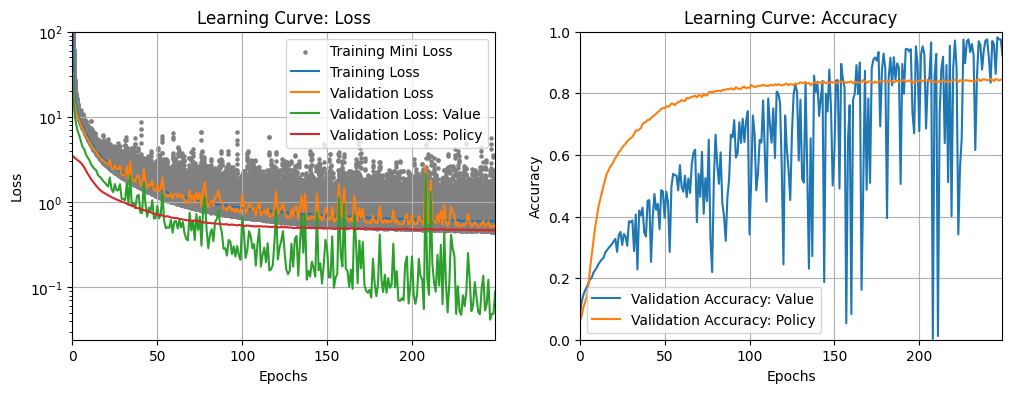

In [49]:
model = StepThreeComboNetwork()
model, train_mini_losses, train_losses, valid_losses, valid_losses_value, valid_losses_policy, valid_accs_value, valid_accs_policy = \
    train_step_three_combo_network(model, train_dataset, valid_dataset, epochs = 250)

plot_learning_curves(train_mini_losses, train_losses, valid_losses, valid_losses_value, valid_losses_policy, valid_accs_value, valid_accs_policy)